In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from bs4 import BeautifulSoup

directory = "../3_cleaning/"

In [2]:
rki_infektion_landkreis_file = '../0_datasets/Aktuell_Deutschland_SarsCov2_Infektionen.csv'
rki_impfung_landkreis_file = "../0_datasets/Aktuell_Deutschland_Landkreise_COVID-19-Impfungen.csv"
regionalschluessel_file = "../0_datasets/Regionalschluessel.txt"
wetterStationen_file = "../0_datasets/wetterStationen.txt"
wetterDaten_file = "../0_datasets/wetterDatenCrawl.txt"

def split(string_to_split):
    splits = [5, 14, 23, 38, 50, 61, 102]
    return_value = list()
    previous = 0
    for position in splits:
        value = string_to_split[previous:position].strip()
        if "(" in value:
            value = value.split("(")[0]
        if "," in value:
            split = value.split(",")
            value = split[1] + " " + split[0]
            value = value.replace("  ", " ").strip()
        return_value.append(value)
        previous = position
    return_value.append(string_to_split[previous:].replace(" ", "").replace("\n", ""))
    return return_value

def read_wetter(path):
    with open(path, "r", encoding="utf-8") as fp:
        lines = fp.readlines()
    header = lines[0]
    lines.remove(header)
    header = header.split()
    arr = np.zeros(shape=(len(lines),len(header)))
    simple_list=[]
    for line in lines:
        result = split(line)
        simple_list.append(result)
    dataframe = pd.DataFrame(simple_list, columns=header)
    return dataframe

In [238]:
#impfung
rki_impfung = pd.read_csv(rki_impfung_landkreis_file, low_memory=False)
rki_impfung = rki_impfung.drop(rki_impfung.columns[[2,3]], axis=1)
rki_impfung = rki_impfung.groupby(['Impfdatum', 'LandkreisId_Impfort'], as_index=False).sum()
rki_impfung = rki_impfung.rename(columns={'Anzahl': 'Impf_Anzahl', 'Impfdatum': 'Datum', 'LandkreisId_Impfort': 'ID'})
rki_impfung["Datum"] = rki_impfung["Datum"].map(lambda x: x.replace("-", ""))
rki_impfung["Datum"] = rki_impfung["Datum"].apply(pd.to_numeric)
rki_impfung = rki_impfung[rki_impfung["ID"] != 'u']
rki_impfung["ID"] = rki_impfung["ID"].apply(pd.to_numeric)

#infektion
rki_infektion = pd.read_csv(rki_infektion_landkreis_file, low_memory=False)
rki_infektion = rki_infektion.drop(rki_infektion.columns[[1,2,3,5,6,7,8,10,11]], axis=1)
rki_infektion = rki_infektion.groupby(['Refdatum', 'IdLandkreis'], as_index=False).sum()
rki_infektion = rki_infektion.rename(columns={'AnzahlFall': 'Infek_Anzahl', 'Refdatum': 'Datum', 'IdLandkreis': 'ID'})
rki_infektion["Datum"] = rki_infektion["Datum"].map(lambda x: x.replace("-", ""))
rki_infektion["Datum"] = rki_infektion["Datum"].apply(pd.to_numeric)
rki_infektion["ID"] = rki_infektion["ID"].apply(pd.to_numeric)

#regionalschlüssel
regional_schluessel = pd.read_csv(regionalschluessel_file, low_memory=False)
regional_schluessel["ID"] = regional_schluessel["ID"].map(lambda x: int(x/10000000))
#regional_schluessel = regional_schluessel.drop_duplicates(subset=['ID'], keep='first')
regional_schluessel = regional_schluessel.rename(columns={'Name': 'Ort'})
regional_schluessel[["ID"]] = regional_schluessel[["ID"]].apply(pd.to_numeric)

#wetterStationen
wetter_stationen = read_wetter(wetterStationen_file)
wetter_stationen = wetter_stationen[wetter_stationen["bis_datum"] == '20220608']
wetter_stationen = wetter_stationen.drop(wetter_stationen.columns[[1,2,3,4,5,7]], axis=1)
wetter_stationen = wetter_stationen.rename(columns={'Stations_id': 'ID', 'Stationsname': 'Ort'})
wetter_stationen[["ID"]] = wetter_stationen[["ID"]].apply(pd.to_numeric)

#wetterDaten
wetter_daten = pd.read_csv(wetterDaten_file, sep = ';', low_memory=False)
wetter_daten = wetter_daten.drop(wetter_daten.columns[[2,3,5,7,9,10,11,12,15,16,17,18]], axis=1)
wetter_daten[["MESS_DATUM"]] = wetter_daten[["MESS_DATUM"]].apply(pd.to_numeric)
wetter_daten = wetter_daten[wetter_daten["MESS_DATUM"] >= 20200119]
wetter_daten = wetter_daten.rename(columns={'STATIONS_ID': 'ID','MESS_DATUM': 'Datum', 'RSK': 'Regenmenge', 'SDK': 'Sonnenschein', 'TMK': 'Temperatur', 'UPM' : 'Feuchte', 'FM' : 'Wind'})
wetter_daten[["ID"]] = wetter_daten[["ID"]].apply(pd.to_numeric)


In [243]:
#join
result = pd.merge(rki_infektion, rki_impfung, on=['Datum','ID'])
result = pd.merge(result, regional_schluessel, on=['ID'])
result = result.drop(result.columns[[1]], axis=1)

wetterResult = pd.merge(wetter_daten, wetter_stationen, on=['ID'])
#wetterResult = wetterResult.drop(wetterResult.columns[[0]], axis=1)

result = pd.merge(result, wetterResult, on=['Datum', 'Ort'])

#result
#with pd.option_context('display.max_rows', None):
#    print(result)
result.to_csv('resultFile.txt', sep=',', encoding='utf-8')

In [244]:
result.loc[result['Ort'] == 'Marburg']

,Datum,Infek_Anzahl,Impf_Anzahl,Ort,ID,Wind,Regenmenge,Sonnenschein,Temperatur,Feuchte
11292,20201227,29,202,Marburg,3164,-999.0,14.1,-999.0,1.4,81.08
11293,20201228,38,76,Marburg,3164,-999.0,0.2,-999.0,3.8,88.21
11294,20201229,36,330,Marburg,3164,-999.0,0.8,-999.0,2.6,87.46
11295,20201230,63,468,Marburg,3164,-999.0,0.1,-999.0,2.6,87.29
11296,20201231,64,336,Marburg,3164,-999.0,4.3,-999.0,1.9,88.79
...,...,...,...,...,...,...,...,...,...,...
11648,20211227,67,1875,Marburg,3164,-999.0,1.8,-999.0,0.7,97.17
11649,20211228,61,2155,Marburg,3164,-999.0,7.3,-999.0,5.3,92.88
11650,20211229,68,2479,Marburg,3164,-999.0,3.9,-999.0,8.0,91.08
11651,20211230,63,1675,Marburg,3164,-999.0,1.9,-999.0,11.9,89.38


In [87]:
import io
import requests
import zipfile
import time
import io

URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/"
resp = requests.get(URL)
parsed_html = BeautifulSoup(resp.text)

header = "STATIONS_ID;MESS_DATUM;QN_3;FX;FM;QN_4;RSK;RSKF;SDK;SHK_TAG;NM;VPM;PM;TMK;UPM;TXK;TNK;TGK;eor"
with open('wetterDatenCrawl.txt', 'w', newline='') as outfile:
    selected = parsed_html.select('a')
    counterEnd = len(selected)
    counter = 0
    for a_tag in selected:
        counter = counter + 1
        splitTxt = a_tag.text.split('_')
        if splitTxt[0] == 'tageswerte' and splitTxt[4] == '20211231':
            zip_file_url = URL + a_tag.text
            r = requests.get(zip_file_url, stream=True)
            z = zipfile.ZipFile(io.BytesIO(r.content))
            nameoftempfile = "produkt_klima_tag_" + splitTxt[3] + "_"+splitTxt[4]+"_"+splitTxt[2]+".txt"
            for line in z.open(nameoftempfile).readlines():
                lineDec = line.decode('utf-8').replace(" ", "")
                if lineDec.startswith('STATIONS_ID'):
                    continue
                lineDecSplit = lineDec.split(';')
                if len(lineDecSplit) < 19:
                    continue
                if int(lineDecSplit[1]) < 20200119:
                    continue
                outfile.write(lineDec)
            print(100 * float(counter)/float(counterEnd), "% \n", end="")
            time.sleep(10)

0.7252215954875101 % 
1.20870265914585 % 
1.2892828364222402 % 
1.36986301369863 % 
1.4504431909750202 % 
1.6116035455278002 % 
1.7727639000805802 % 
1.9339242546333602 % 
2.17566478646253 % 
2.3368251410153102 % 
2.4174053182917 % 
2.4979854955680905 % 
2.5785656728444803 % 
2.6591458501208702 % 
2.73972602739726 % 
2.8203062046736505 % 
3.3843674456083805 % 
3.7066881547139405 % 
3.8678485092667203 % 
3.94842868654311 % 
4.270749395648671 % 
4.43190975020145 % 
4.59307010475423 % 
4.754230459307011 % 
4.8348106365834 % 
5.07655116841257 % 
5.398871877518131 % 
5.47945205479452 % 
5.560032232070911 % 
5.640612409347301 % 
5.72119258662369 % 
5.9629331184528604 % 
6.12409347300564 % 
6.526994359387591 % 
6.60757453666398 % 
6.688154713940371 % 
6.8493150684931505 % 
7.091055600322321 % 
7.2522159548751 % 
7.816277195809831 % 
8.138597904915391 % 
8.460918614020951 % 
8.70265914585012 % 
8.8638195004029 % 
9.347300564061241 % 
9.991941982272362 % 
10.15310233682514 % 
10.394842868654312

76.71232876712328 % 
76.87348912167607 % 
76.95406929895246 % 
77.03464947622885 % 
77.27639000805802 % 
77.59871071716358 % 
78.1627719580983 % 
78.32393231265108 % 
78.40451248992748 % 
78.88799355358582 % 
79.12973408541498 % 
79.29089443996777 % 
79.37147461724416 % 
79.53263497179694 % 
79.61321514907333 % 
79.85495568090249 % 
80.01611603545528 % 
80.25785656728445 % 
80.41901692183723 % 
80.58017727639 % 
80.66075745366639 % 
80.90249798549557 % 
81.14423851732474 % 
81.70829975825947 % 
81.86946011281225 % 
82.11120064464141 % 
82.1917808219178 % 
82.3529411764706 % 
82.51410153102337 % 
82.75584206285254 % 
83.23932312651088 % 
83.31990330378727 % 
83.48106365834005 % 
83.8033843674456 % 
84.04512489927478 % 
84.20628525382756 % 
84.28686543110395 % 
84.44802578565672 % 
84.6091861402095 % 
84.6897663174859 % 
84.93150684931507 % 
85.09266720386785 % 
85.17324738114424 % 
85.4149879129734 % 
85.5761482675262 % 
85.65672844480258 % 
85.73730862207897 % 
85.97904915390814 % 
86.

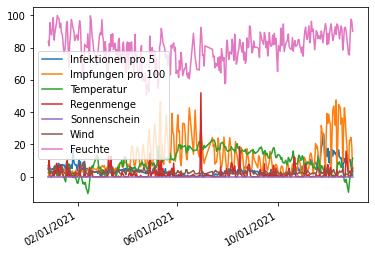

In [257]:
from random import randrange

plotdata = result[["Ort","Datum", 'Regenmenge', 'Sonnenschein', "Temperatur", "Infek_Anzahl", "Impf_Anzahl", "Wind", "Feuchte"]]
plotdata = plotdata[plotdata["Ort"] == 'Lübeck']
plotdata = plotdata[plotdata["Datum"] < 20220607]
plotdata["Datum"] = plotdata["Datum"].map(lambda x: datetime.strptime(str(x), '%Y%m%d'))
plotdata = plotdata[plotdata['Regenmenge'] > -999.0]
plotdata['Sonnenschein'] = plotdata['Sonnenschein'].map(lambda x: 0)
plotdata['Impf_Anzahl'] = plotdata['Impf_Anzahl'].map(lambda x: x/100)
plotdata['Infek_Anzahl'] = plotdata['Infek_Anzahl'].map(lambda x: x/5)
plotdata = plotdata[plotdata['Feuchte'] > -999.0]
plotdata = plotdata[plotdata['Wind'] > -999.0]
#plotdata = plotdata[plotdata['Temperatur'] > -999.0]
#plotdata['Temperatur'] = plotdata['Temperatur'].rolling(window=7).mean() 
#plotdata['Regenmenge'] = plotdata['Regenmenge'].rolling(window=7).mean() 
#plotdata['Sonnenschein'] = plotdata['Sonnenschein'].rolling(window=7).mean()
#plotdata['Infek_Anzahl'] = plotdata['Infek_Anzahl'].rolling(window=7).mean() 
#plotdata['Impf_Anzahl'] = plotdata['Impf_Anzahl'].rolling(window=7).mean() 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.plot(plotdata['Datum'],plotdata['Infek_Anzahl'],label="Infektionen pro 5")
plt.plot(plotdata['Datum'],plotdata['Impf_Anzahl'],label="Impfungen pro 100")
plt.plot(plotdata['Datum'],plotdata['Temperatur'],label="Temperatur")
plt.plot(plotdata['Datum'],plotdata['Regenmenge'],label="Regenmenge")
plt.plot(plotdata['Datum'],plotdata['Sonnenschein'],label="Sonnenschein")
plt.plot(plotdata['Datum'],plotdata['Wind'],label="Wind")
plt.plot(plotdata['Datum'],plotdata['Feuchte'],label="Feuchte")
plt.legend()
plt.gcf().autofmt_xdate()
#plt.savefig(directory + str(randrange(100)) + 'sample.png', dpi=1200)
plt.show()

In [191]:
from scipy.stats.stats import pearsonr
('Bad Bergzabern', 'Lübeck', 'Tholey', 'Fichtelberg')
plotdata = result[["Ort","Datum", 'Regenmenge', 'Sonnenschein', "Temperatur", "Infek_Anzahl", "Impf_Anzahl"]]
plotdata = plotdata[plotdata["Ort"] == 'Fichtelberg']
plotdata = plotdata[plotdata["Datum"] < 20220607]
plotdata["Datum"] = plotdata["Datum"].map(lambda x: datetime.strptime(str(x), '%Y%m%d'))
print(len(plotdata['Regenmenge'].unique()))
print(len(plotdata['Sonnenschein'].unique()))
print(len(plotdata['Temperatur'].unique()))
plotdata = plotdata[plotdata['Regenmenge'] > -999.0]
plotdata = plotdata[plotdata['Sonnenschein'] > -999.0]
plotdata = plotdata[plotdata['Temperatur'] > -999.0]

name = list()
length = list()
p = list()
name.append('Temp/Infekt')
name.append('Temp/Impf')
name.append('Sonne/Infekt')
name.append('Sonne/Impf')
name.append('Regen/Infekt')
name.append('Regen/Impf')

length.append(pearsonr(plotdata['Temperatur'],plotdata['Infek_Anzahl'])[0])
length.append(pearsonr(plotdata['Temperatur'],plotdata['Impf_Anzahl'])[0])
length.append(pearsonr(plotdata['Sonnenschein'],plotdata['Infek_Anzahl'])[0])
length.append(pearsonr(plotdata['Sonnenschein'],plotdata['Impf_Anzahl'])[0])
length.append(pearsonr(plotdata['Regenmenge'],plotdata['Infek_Anzahl'])[0])
length.append(pearsonr(plotdata['Regenmenge'],plotdata['Impf_Anzahl'])[0])

p.append(pearsonr(plotdata['Temperatur'],plotdata['Infek_Anzahl'])[1])
p.append(pearsonr(plotdata['Temperatur'],plotdata['Impf_Anzahl'])[1])
p.append(pearsonr(plotdata['Sonnenschein'],plotdata['Infek_Anzahl'])[1])
p.append(pearsonr(plotdata['Sonnenschein'],plotdata['Impf_Anzahl'])[1])
p.append(pearsonr(plotdata['Regenmenge'],plotdata['Infek_Anzahl'])[1])
p.append(pearsonr(plotdata['Regenmenge'],plotdata['Impf_Anzahl'])[1])

64
118
125


[-0.5163269654316438, -0.06561967370319606, -0.3030863240232824, 0.020190608515003962, -0.02833242151697617, -0.02344115826480312]


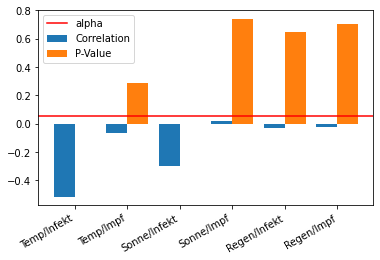

In [216]:
x = np.arange(6)
ax = plt.subplot(111)
width = 0.4
print(length)
ax.bar(x, length, width=width, align='center')
ax.bar(x + width, p, width=width,align='center')
ax.axhline(y=0.05, color='r', linestyle='-')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(name)
ax.legend(('alpha', 'Correlation', 'P-Value'))
plt.gcf().autofmt_xdate()
#plt.savefig(directory + str(randrange(100)) + 'corr.png', dpi=1200)
#ax.show()

In [318]:
def computeWetter(a, index, mean, minL, maxL):
    mean[index][0] = mean[index][0] + a[0]
    mean[index][1] = mean[index][1] + a[1]
    if minL[index][0] > a[0]:
        minL[index][0] = a[0]
        minL[index][1] = a[1]
    elif maxL[index][0] < a[0]:
        maxL[index][0] = a[0]
        maxL[index][1] = a[1]

In [319]:
import itertools
plotdata = result[["Ort","Datum", 'Regenmenge', 'Sonnenschein', "Temperatur", "Infek_Anzahl", "Impf_Anzahl", "Feuchte", "Wind"]]

name = list()
name.append('Temp/Infekt')
name.append('Temp/Impf')
name.append('Wind/Infekt')
name.append('Wind/Impf')
name.append('Regen/Infekt')
name.append('Regen/Impf')
name.append('Sonne/Infekt')
name.append('Sonne/Impf')
name.append('Feuchte/Infekt')
name.append('Feuchte/Impf')
#plotdata['Temperatur'].rolling(window=7).mean() 
#plotdata['Feuchte'].rolling(window=7).mean() 
#plotdata['Wind'].rolling(window=7).mean() 
#plotdata['Regenmenge'].rolling(window=7).mean() 
#plotdata['Sonnenschein'].rolling(window=7).mean()
#plotdata['Infek_Anzahl'].rolling(window=7).mean() 
#plotdata['Impf_Anzahl'].rolling(window=7).mean()

maxL = [[-100,0],[-100,0],[-100,0],[-100,0],[-100,0],[-100,0],[-100,0],[-100,0],[-100,0],[-100,0]]
minL = [[100,0],[100,0],[100,0],[100,0],[100,0],[100,0],[100,0],[100,0],[100,0],[100,0]]
mean = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
meanCounter = [0,0,0,0,0]
x = plotdata.groupby(by=["Ort"], as_index=False).sum()
for index, row in x.iterrows():
    ort = row['Ort']
    tempData = plotdata[plotdata["Ort"] == ort]
    #tempData = tempData[tempData["Datum"] < 20220607]
    #tempData["Datum"] = tempData["Datum"].map(lambda x: datetime.strptime(str(x), '%Y%m%d'))

    tempWetterDaten = tempData[tempData['Temperatur'] > -999.0]
    if len(tempWetterDaten['Temperatur'].unique()) > 100:
        meanCounter[0] = meanCounter[0] + 1
        a = pearsonr(tempWetterDaten['Temperatur'],tempWetterDaten['Infek_Anzahl'])
        b = pearsonr(tempWetterDaten['Temperatur'],tempWetterDaten['Impf_Anzahl'])
        computeWetter(a, 0, mean, minL, maxL)
        computeWetter(b, 1, mean, minL, maxL)
    tempWetterDaten = tempData[tempData['Feuchte'] > -999.0]
    if len(tempWetterDaten['Feuchte'].unique()) > 100:
        meanCounter[4] = meanCounter[4] + 1
        a = pearsonr(tempWetterDaten['Feuchte'],tempWetterDaten['Infek_Anzahl'])
        b = pearsonr(tempWetterDaten['Feuchte'],tempWetterDaten['Impf_Anzahl'])
        computeWetter(a, 8, mean, minL, maxL)
        computeWetter(b, 9, mean, minL, maxL)
    tempWetterDaten = tempData[tempData['Wind'] > -999.0]
    if len(tempWetterDaten['Wind'].unique()) > 100:
        meanCounter[1] = meanCounter[1] + 1
        a = pearsonr(tempWetterDaten['Wind'],tempWetterDaten['Infek_Anzahl'])
        b = pearsonr(tempWetterDaten['Wind'],tempWetterDaten['Impf_Anzahl'])
        computeWetter(a, 2, mean, minL, maxL)
        computeWetter(b, 3, mean, minL, maxL)
    tempWetterDaten = tempData[tempData['Regenmenge'] > -999.0]
    if len(tempWetterDaten['Regenmenge'].unique()) > 100:
        meanCounter[2] = meanCounter[2] + 1
        a = pearsonr(tempWetterDaten['Regenmenge'],tempWetterDaten['Infek_Anzahl'])
        b = pearsonr(tempWetterDaten['Regenmenge'],tempWetterDaten['Impf_Anzahl'])
        computeWetter(a, 4, mean, minL, maxL)
        computeWetter(b, 5, mean, minL, maxL)
    tempWetterDaten = tempData[tempData['Sonnenschein'] > -999.0]
    if len(tempWetterDaten['Sonnenschein'].unique()) > 100:
        meanCounter[3] = meanCounter[3] + 1
        a = pearsonr(tempWetterDaten['Sonnenschein'],tempWetterDaten['Infek_Anzahl'])
        b = pearsonr(tempWetterDaten['Sonnenschein'],tempWetterDaten['Impf_Anzahl'])
        computeWetter(a, 6, mean, minL, maxL)
        computeWetter(b, 7, mean, minL, maxL)

i = 0

mean1 = list()
meanP = list()
maxL2 = list()
maxLP = list()
minL3 = list()
minLP = list()
i = 0
for x in mean:
    mean1.append(x[0]/meanCounter[int(i/2)])
    meanP.append(x[1]/meanCounter[int(i/2)])
    i = i+1
for x in maxL:
    if x[0] == -100:
        maxL2.append(0)
        maxLP.append(0)
    else:
        maxL2.append(x[0])
        maxLP.append(x[1])
for x in minL:
    minL3.append(x[0])
    minLP.append(x[1])

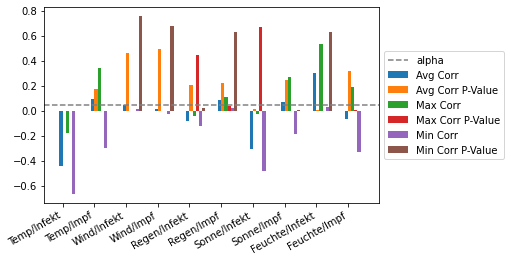

In [320]:
x = np.arange(10)
ax = plt.subplot(111)
width = 0.1

ax.bar(x, mean1, width=width, align='center')
ax.bar(x + width, meanP, width=width,align='center')
ax.bar(x + width*2, maxL2, width=width,align='center')
ax.bar(x + width*3, maxLP, width=width,align='center')
ax.bar(x + width*4, minL3, width=width,align='center')
ax.bar(x + width*5, minLP, width=width,align='center')
ax.axhline(y=0.05, color='gray', linestyle='--')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(name)
ax.legend(('alpha', 'Avg Corr', 'Avg Corr P-Value', 'Max Corr', 'Max Corr P-Value', 'Min Corr', 'Min Corr P-Value'), loc='center left', bbox_to_anchor=(1, 0.5))
plt.gcf().autofmt_xdate()
plt.savefig(directory + str(randrange(100)) + 'corr.png', dpi=1200, bbox_inches='tight')
#ax.show()